# Evaluate Translations

In [15]:
_DATASETS = [
    "xstory_cloze",
    "xcopa",
    "xnli",
    # "paws-x",
    # "mgsm",
]

_MODELS = [
    "nllb-200-distilled-600M",
    "nllb-200-distilled-1.3B",
    "nllb-200-1.3B",
    "nllb-200-3.3B",
    "xglm-564M",
    "xglm-1.7B",
    "xglm-2.9B",
    #"xglm-4.5B",
    "xglm-7.5B",
    "bloom-560m",
    #"bloom-1b1",
    "bloom-1b7",
    "bloom-3b",
    "bloom-7b1",
    "llama-7B",
    "llama-13B",
    "llama-30B",
    # "llama-65B",
    #"RedPajama-INCITE-Base-3B-v1",
    #"RedPajama-INCITE-7B-Base",
    #"open_llama_3b",
    #"open_llama_7b",
    #"open_llama_13b",
]

In [16]:
"""_MODELS = [
    "nllb-200-3.3B",
    "xglm-564M",
    "xglm-1.7B",
    "xglm-2.9B",
    "xglm-7.5B",
]"""

model_sizes = {
    "nllb": [0.6, 1.3, 1.3, 3.3],
    "xglm": [0.6, 1.7, 2.9, 7.5],
    "bloom": [0.6, 1.7, 3.0, 7.1],
    "llama": [7.0, 13.0, 30.0], 
}

model_names_all = ["nllb"] * 4 + ["xglm"] * 4 + ["bloom"] * 4 + ["llama"] * 3

# list including all models
model_sizes_all = []
for sizes in model_sizes.values():
    model_sizes_all += sizes

In [17]:
# mikel
languages = {
    "high": ["es", "ru", "zh", "it", "id"],
    "low": ["sw", "hi", "ur", "my", "ta", "ht"]
}

# xglm
languages = {
    "high": ["ru", "zh", "de", "es", "fr", "ja"],
    # "medium": ["it", "pt", "el", "ko", "fi", "id", "tr", "ar", "vi", "th", "bg", "ca"],
    "low": ["hi", "et", "bn", "ta", "ur", "sw", "te", "eu", "my", "ht", "qu"],
    # "ex_low": ["eu", "my", "ht", "qu"]
}

# languages = {}

In [18]:
# Get results from metrics folder

from collections import defaultdict
import json

def get_metrics():
    metrics_dict = defaultdict(dict)
    for dataset_name in _DATASETS:
        for model_name in _MODELS:
            if model_name == "bloom-560m" and dataset_name == "xnli":
                with open(f"metrics/{dataset_name}/bloom-1b1.json") as f:
                    metrics_dict[dataset_name][model_name] = json.load(f)
            else:
                with open(f"metrics/{dataset_name}/{model_name}.json") as f:
                    metrics_dict[dataset_name][model_name] = json.load(f)
            for language in metrics_dict[dataset_name][model_name]:
                avg = defaultdict(float)
                for field in metrics_dict[dataset_name][model_name][language]:
                    for metric, value in metrics_dict[dataset_name][model_name][language][field].items():
                        avg[metric] += value
                for metric in avg:
                    avg[metric] /= len(metrics_dict[dataset_name][model_name][language])
                    avg[metric] = round(avg[metric], 2)
                metrics_dict[dataset_name][model_name][language]["avg"] = dict(avg)
                        
                
    return dict(metrics_dict)
                
metrics_dict = get_metrics()

In [19]:
from copy import deepcopy

def add_avg(metrics_dict):
    metrics_dict_split = defaultdict(dict)

    for metric in ["sacrebleu", "chrf++", "comet"]:
        metrics_dict_split[metric] = deepcopy(metrics_dict)
        for dataset_name in metrics_dict:
            for model_name in metrics_dict[dataset_name]:
                """
                if model_name == "bloom-560m" and dataset_name == "xnli":
                    continue
                """
                for language, language_dict in metrics_dict[dataset_name][model_name].items():
                    avg = metrics_dict[dataset_name][model_name][language]["avg"]
                    metrics_dict_split[metric][dataset_name][model_name][language] = avg.get(metric, 0)
                metrics_dict_split[metric][dataset_name][model_name]["avg"] = round(sum(metrics_dict_split[metric][dataset_name][model_name].values()) / len(metrics_dict_split[metric][dataset_name][model_name]), 2)
                
                items = metrics_dict_split[metric][dataset_name][model_name]
                values = items.values()
                metrics_dict_split[metric][dataset_name][model_name]["avg"] = round(sum(values) / len(values), 1)
                for resource, langs in languages.items():
                    values = [v for k, v in items.items() if k in langs]
                    if len(values) > 0:
                        metrics_dict_split[metric][dataset_name][model_name][resource] = round(sum(values) / len(values), 1)
    return dict(metrics_dict_split)

metrics_dict_split = add_avg(metrics_dict)


In [22]:
import matplotlib.pyplot as plt

def plot_size_df_datasets(df, model_name, title, langs=False):
    df.set_index("size", inplace=True)
    # select only the model
    df_model = df[df["model"] == model_name]
    for average in ["avg"] + list(languages.keys()):
        if average not in df.columns:
            continue
        df_model[average].plot(
            x="size", y="acc", title=f"{title} {average}" if title else "", ylabel="Average COMET", xlabel="Model size (B)", legend=True, marker="o", label="Self-translate", color="C2"
        )
        # add an horizontal line with NLLB-200-3.3B
        plt.axhline(y=df.loc[3.3][average], color="C1", linestyle="--", label="MT (NLLB)")
        plt.legend()
        plt.xscale("log")
        # vertical scale from 0 to 45
        #plt.ylim(0, 45)
        plt.ylim(55, 90)
        plt.xticks(model_sizes[model_name], model_sizes[model_name], rotation="vertical");
        if title == "":
            plt.savefig(f"plots/{average}.pdf", bbox_inches='tight')
        plt.show()
    # iterate all langs
    if langs:
        for lang in df.columns:
            if lang in ["dataset", "avg", "size"]:
                continue
            df[lang].plot(x="size", y="acc", title=f"{title}_{lang}", ylabel="BLEU", xlabel="Model size (B)", legend=True, marker="o")
            plt.xscale("log")
            plt.xticks(model_sizes[model_name], model_sizes[model_name], rotation="vertical");
            plt.show()

,model,size,ru,zh,es,ar,hi,id,te,sw,eu,my,avg,high,low
nllb-200-distilled-600M,nllb,0.6,87.07,85.00,89.36,88.39,90.52,88.08,86.44,86.04,86.87,81.35,86.9,87.1,86.2
nllb-200-distilled-1.3B,nllb,1.3,88.44,86.02,90.33,89.85,91.56,89.14,87.64,87.31,86.92,85.26,88.2,88.3,87.7
nllb-200-1.3B,nllb,1.3,88.18,86.36,90.22,89.83,91.39,89.05,87.30,87.21,87.25,85.99,88.3,88.3,87.8
nllb-200-3.3B,nllb,3.3,88.63,87.54,90.54,90.36,91.70,89.54,88.00,87.46,86.92,86.60,88.7,88.9,88.1
xglm-564M,xglm,0.6,73.05,54.47,72.08,61.44,68.85,77.52,57.04,58.63,59.52,50.99,63.4,66.5,59.0
xglm-1.7B,xglm,1.7,80.96,77.26,81.95,76.35,77.48,83.96,74.09,75.15,71.25,73.03,77.1,80.1,74.2
xglm-2.9B,xglm,2.9,83.36,82.11,85.61,79.84,82.99,85.66,75.43,79.71,79.32,77.47,81.1,83.7,79.0
xglm-7.5B,xglm,7.5,85.76,84.25,87.81,83.81,86.25,87.60,80.66,82.92,82.05,81.36,84.2,85.9,82.6
bloom-560m,bloom,0.6,43.20,70.47,73.65,72.18,73.40,79.31,58.06,42.03,55.73,47.25,61.5,62.4,55.3
bloom-1b7,bloom,1.7,60.47,82.81,85.44,80.40,81.05,85.06,72.48,66.06,71.98,50.69,73.6,76.2,68.5


\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
model &  size &    ru &    zh &    es &    ar &    hi &    id &    te &    sw &    eu &    my &  avg &  high &  low \\
\midrule
 nllb &   0.6 & 87.07 & 85.00 & 89.36 & 88.39 & 90.52 & 88.08 & 86.44 & 86.04 & 86.87 & 81.35 & 86.9 &  87.1 & 86.2 \\
 nllb &   1.3 & 88.44 & 86.02 & 90.33 & 89.85 & 91.56 & 89.14 & 87.64 & 87.31 & 86.92 & 85.26 & 88.2 &  88.3 & 87.7 \\
 nllb &   1.3 & 88.18 & 86.36 & 90.22 & 89.83 & 91.39 & 89.05 & 87.30 & 87.21 & 87.25 & 85.99 & 88.3 &  88.3 & 87.8 \\
 nllb &   3.3 & 88.63 & 87.54 & 90.54 & 90.36 & 91.70 & 89.54 & 88.00 & 87.46 & 86.92 & 86.60 & 88.7 &  88.9 & 88.1 \\
 xglm &   0.6 & 73.05 & 54.47 & 72.08 & 61.44 & 68.85 & 77.52 & 57.04 & 58.63 & 59.52 & 50.99 & 63.4 &  66.5 & 59.0 \\
 xglm &   1.7 & 80.96 & 77.26 & 81.95 & 76.35 & 77.48 & 83.96 & 74.09 & 75.15 & 71.25 & 73.03 & 77.1 &  80.1 & 74.2 \\
 xglm &   2.9 & 83.36 & 82.11 & 85.61 & 79.84 & 82.99 & 85.66 & 75.43 & 79.71 & 79.32 & 77.47 & 81.1 &  83.7 & 79.0 

/tmp/ipykernel_964818/569464905.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


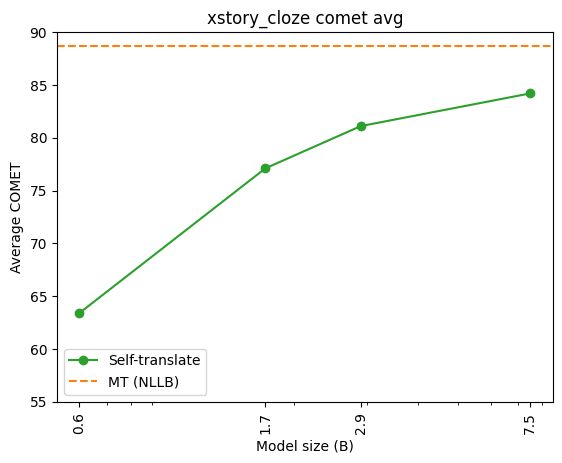

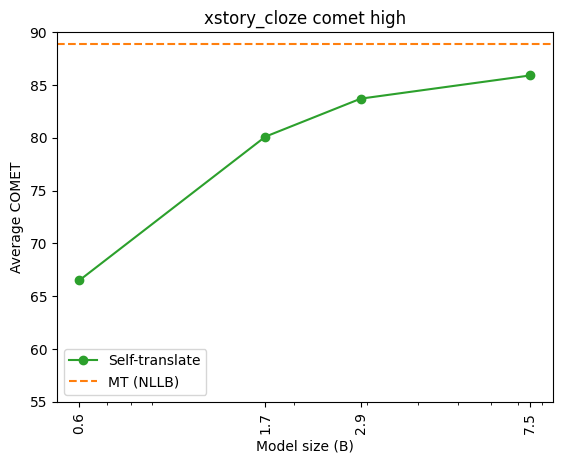

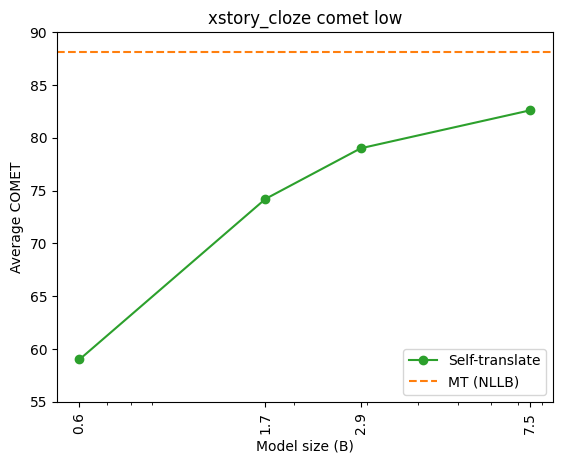

,model,size,et,ht,it,id,qu,sw,zh,ta,th,tr,vi,avg,high,low
nllb-200-distilled-600M,nllb,0.6,82.78,75.42,86.49,85.23,62.17,79.74,84.66,83.93,76.30,84.54,81.97,80.3,84.7,76.8
nllb-200-distilled-1.3B,nllb,1.3,86.57,78.88,88.95,87.44,64.26,82.01,87.07,86.50,78.79,86.97,84.29,82.9,87.1,79.6
nllb-200-1.3B,nllb,1.3,85.38,77.84,88.50,86.86,62.97,81.43,86.44,85.79,77.72,86.31,83.55,82.1,86.4,78.7
nllb-200-3.3B,nllb,3.3,86.76,79.16,89.16,87.56,63.87,82.08,87.85,86.60,80.10,87.42,85.23,83.3,87.8,79.7
xglm-564M,xglm,0.6,68.27,58.08,65.79,73.98,34.54,54.72,50.21,64.52,71.24,64.44,68.33,61.3,50.2,56.0
xglm-1.7B,xglm,1.7,78.78,67.84,79.09,81.47,50.98,69.01,80.06,77.22,77.88,74.84,77.87,74.1,80.1,68.8
xglm-2.9B,xglm,2.9,83.16,71.97,82.96,84.22,50.82,74.41,83.93,79.67,81.37,78.98,82.23,77.6,83.9,72.0
xglm-7.5B,xglm,7.5,85.49,72.47,85.19,86.04,55.33,77.29,85.41,83.47,82.36,81.38,83.61,79.8,85.4,74.8
bloom-560m,bloom,0.6,41.78,41.47,48.71,75.73,37.32,40.93,75.23,65.09,42.51,50.09,75.22,54.0,75.2,45.3
bloom-1b7,bloom,1.7,45.41,46.04,65.38,82.57,45.08,58.94,84.71,76.72,46.41,48.74,81.43,61.9,84.7,54.4


/tmp/ipykernel_964818/569464905.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
model &  size &    et &    ht &    it &    id &    qu &    sw &    zh &    ta &    th &    tr &    vi &  avg &  high &  low \\
\midrule
 nllb &   0.6 & 82.78 & 75.42 & 86.49 & 85.23 & 62.17 & 79.74 & 84.66 & 83.93 & 76.30 & 84.54 & 81.97 & 80.3 &  84.7 & 76.8 \\
 nllb &   1.3 & 86.57 & 78.88 & 88.95 & 87.44 & 64.26 & 82.01 & 87.07 & 86.50 & 78.79 & 86.97 & 84.29 & 82.9 &  87.1 & 79.6 \\
 nllb &   1.3 & 85.38 & 77.84 & 88.50 & 86.86 & 62.97 & 81.43 & 86.44 & 85.79 & 77.72 & 86.31 & 83.55 & 82.1 &  86.4 & 78.7 \\
 nllb &   3.3 & 86.76 & 79.16 & 89.16 & 87.56 & 63.87 & 82.08 & 87.85 & 86.60 & 80.10 & 87.42 & 85.23 & 83.3 &  87.8 & 79.7 \\
 xglm &   0.6 & 68.27 & 58.08 & 65.79 & 73.98 & 34.54 & 54.72 & 50.21 & 64.52 & 71.24 & 64.44 & 68.33 & 61.3 &  50.2 & 56.0 \\
 xglm &   1.7 & 78.78 & 67.84 & 79.09 & 81.47 & 50.98 & 69.01 & 80.06 & 77.22 & 77.88 & 74.84 & 77.87 & 74.1 &  80.1 & 68.8 \\
 xglm &   2.9 & 83.16 & 71.97 & 82.96 & 84.22 & 50.82 & 74.

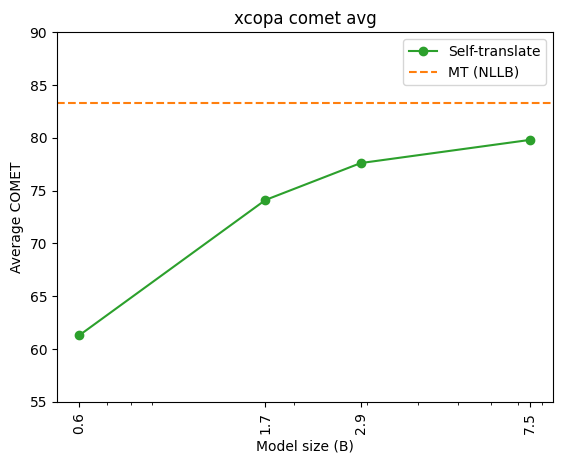

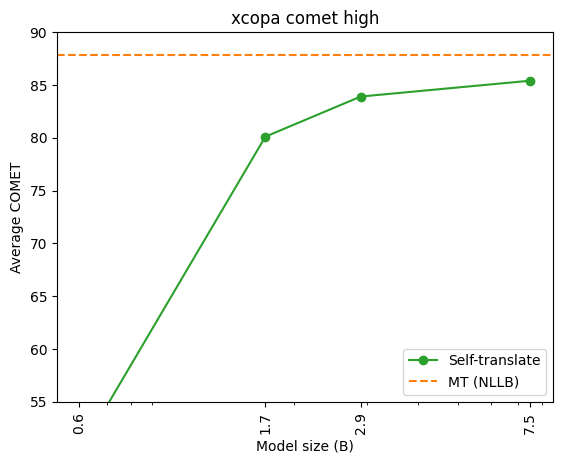

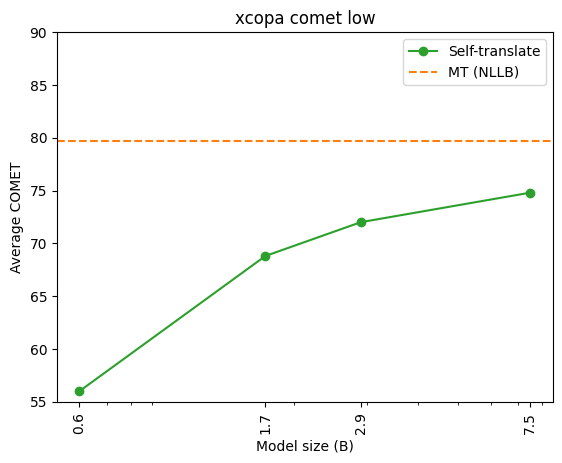

,model,size,ar,bg,de,el,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,high,low
nllb-200-distilled-600M,nllb,0.6,83.91,86.05,87.17,87.14,88.19,87.09,85.53,82.75,80.69,82.53,85.94,80.09,85.02,82.64,84.6,85.6,82.1
nllb-200-distilled-1.3B,nllb,1.3,85.27,86.97,88.16,88.04,88.74,87.84,86.38,83.78,82.06,83.71,87.08,81.13,86.03,83.52,85.6,86.4,83.2
nllb-200-1.3B,nllb,1.3,84.92,86.91,88.00,88.02,88.73,87.82,86.22,83.66,81.82,83.37,86.92,81.06,85.84,83.63,85.5,86.4,83.0
nllb-200-3.3B,nllb,3.3,85.38,87.19,88.29,88.40,88.97,88.07,86.74,84.05,82.22,84.22,87.40,81.53,86.31,84.47,85.9,86.8,83.5
xglm-564M,xglm,0.6,60.80,73.87,73.76,71.82,72.89,74.99,64.73,69.33,57.49,65.94,62.75,60.62,65.27,52.02,66.2,68.6,60.9
xglm-1.7B,xglm,1.7,72.72,80.62,80.64,81.78,80.82,80.95,72.41,76.01,69.78,76.53,72.42,67.55,76.38,73.10,75.8,78.3,69.9
xglm-2.9B,xglm,2.9,75.17,82.24,83.02,83.77,82.63,82.55,77.06,78.67,73.39,77.61,75.16,71.51,79.16,77.66,78.5,80.9,74.0
xglm-7.5B,xglm,7.5,79.66,84.69,85.78,85.73,85.97,85.55,80.19,81.00,77.22,81.23,79.88,74.83,81.87,79.85,81.7,83.6,77.4
bloom-560m,bloom,0.6,74.45,47.03,63.00,46.67,82.34,82.67,74.18,48.84,53.88,46.89,49.18,66.12,78.31,76.58,63.6,70.7,64.7
bloom-1b7,bloom,1.7,77.11,51.94,67.78,50.11,84.05,84.46,76.28,61.11,62.78,49.06,50.15,69.20,80.43,78.53,67.4,75.2,69.4


\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
model &  size &    ar &    bg &    de &    el &    es &    fr &    hi &    ru &    sw &    th &    tr &    ur &    vi &    zh &  avg &  high &  low \\
\midrule
 nllb &   0.6 & 83.91 & 86.05 & 87.17 & 87.14 & 88.19 & 87.09 & 85.53 & 82.75 & 80.69 & 82.53 & 85.94 & 80.09 & 85.02 & 82.64 & 84.6 &  85.6 & 82.1 \\
 nllb &   1.3 & 85.27 & 86.97 & 88.16 & 88.04 & 88.74 & 87.84 & 86.38 & 83.78 & 82.06 & 83.71 & 87.08 & 81.13 & 86.03 & 83.52 & 85.6 &  86.4 & 83.2 \\
 nllb &   1.3 & 84.92 & 86.91 & 88.00 & 88.02 & 88.73 & 87.82 & 86.22 & 83.66 & 81.82 & 83.37 & 86.92 & 81.06 & 85.84 & 83.63 & 85.5 &  86.4 & 83.0 \\
 nllb &   3.3 & 85.38 & 87.19 & 88.29 & 88.40 & 88.97 & 88.07 & 86.74 & 84.05 & 82.22 & 84.22 & 87.40 & 81.53 & 86.31 & 84.47 & 85.9 &  86.8 & 83.5 \\
 xglm &   0.6 & 60.80 & 73.87 & 73.76 & 71.82 & 72.89 & 74.99 & 64.73 & 69.33 & 57.49 & 65.94 & 62.75 & 60.62 & 65.27 & 52.02 & 66.2 &  68.6 & 60.9 \\
 xglm &   1.7 & 72.72 & 80.62 & 80.64 &

/tmp/ipykernel_964818/569464905.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


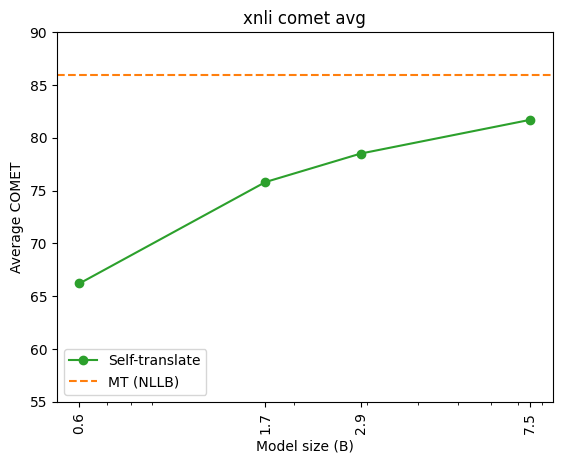

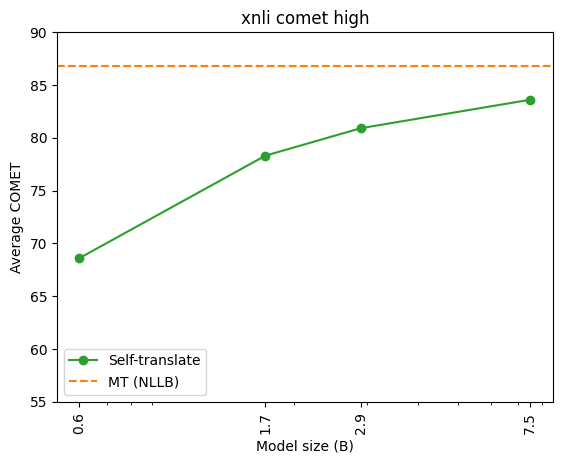

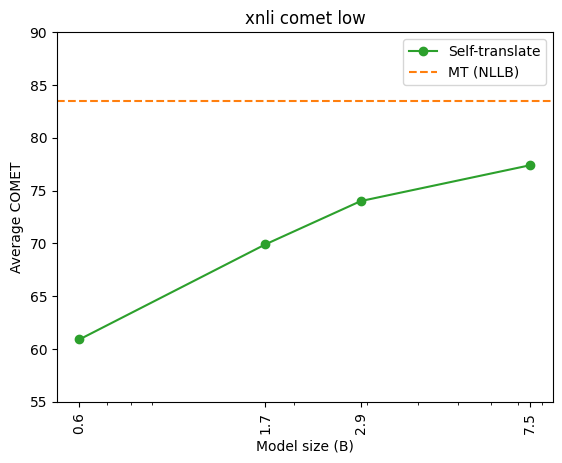

/tmp/ipykernel_964818/569464905.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg[average][average] = df_avg[average].mean(axis=1).round(1)


,model,size,xstory_cloze,xcopa,xnli,avg
nllb-200-distilled-600M,nllb,0.6,86.9,80.3,84.6,83.9
nllb-200-distilled-1.3B,nllb,1.3,88.2,82.9,85.6,85.6
nllb-200-1.3B,nllb,1.3,88.3,82.1,85.5,85.3
nllb-200-3.3B,nllb,3.3,88.7,83.3,85.9,86.0
xglm-564M,xglm,0.6,63.4,61.3,66.2,63.6
xglm-1.7B,xglm,1.7,77.1,74.1,75.8,75.7
xglm-2.9B,xglm,2.9,81.1,77.6,78.5,79.1
xglm-7.5B,xglm,7.5,84.2,79.8,81.7,81.9
bloom-560m,bloom,0.6,61.5,54.0,63.6,59.7
bloom-1b7,bloom,1.7,73.6,61.9,67.4,67.6


/tmp/ipykernel_964818/569464905.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_avg[average].to_latex(index=False))


\begin{tabular}{lrrrrr}
\toprule
model &  size &  xstory\_cloze &  xcopa &  xnli &  avg \\
\midrule
 nllb &   0.6 &          86.9 &   80.3 &  84.6 & 83.9 \\
 nllb &   1.3 &          88.2 &   82.9 &  85.6 & 85.6 \\
 nllb &   1.3 &          88.3 &   82.1 &  85.5 & 85.3 \\
 nllb &   3.3 &          88.7 &   83.3 &  85.9 & 86.0 \\
 xglm &   0.6 &          63.4 &   61.3 &  66.2 & 63.6 \\
 xglm &   1.7 &          77.1 &   74.1 &  75.8 & 75.7 \\
 xglm &   2.9 &          81.1 &   77.6 &  78.5 & 79.1 \\
 xglm &   7.5 &          84.2 &   79.8 &  81.7 & 81.9 \\
bloom &   0.6 &          61.5 &   54.0 &  63.6 & 59.7 \\
bloom &   1.7 &          73.6 &   61.9 &  67.4 & 67.6 \\
bloom &   3.0 &          76.3 &   63.3 &  69.5 & 69.7 \\
bloom &   7.1 &          78.8 &   66.4 &  73.1 & 72.8 \\
llama &   7.0 &          66.8 &   59.4 &  71.5 & 65.9 \\
llama &  13.0 &          68.8 &   61.8 &  75.0 & 68.5 \\
llama &  30.0 &          71.7 &   65.0 &  78.4 & 71.7 \\
\bottomrule
\end{tabular}



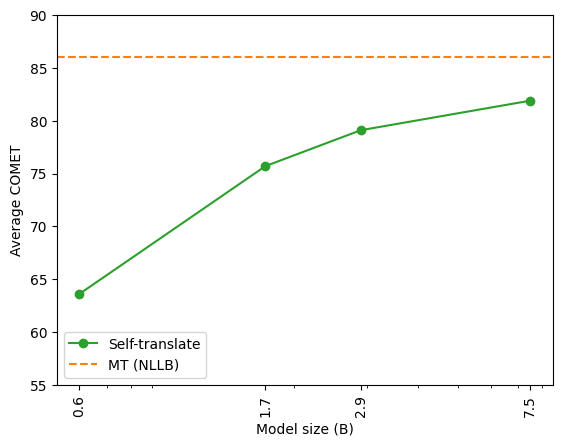

/tmp/ipykernel_964818/569464905.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg[average][average] = df_avg[average].mean(axis=1).round(1)


,model,size,xstory_cloze,xcopa,xnli,high
nllb-200-distilled-600M,nllb,0.6,87.1,84.7,85.6,85.8
nllb-200-distilled-1.3B,nllb,1.3,88.3,87.1,86.4,87.3
nllb-200-1.3B,nllb,1.3,88.3,86.4,86.4,87.0
nllb-200-3.3B,nllb,3.3,88.9,87.8,86.8,87.8
xglm-564M,xglm,0.6,66.5,50.2,68.6,61.8
xglm-1.7B,xglm,1.7,80.1,80.1,78.3,79.5
xglm-2.9B,xglm,2.9,83.7,83.9,80.9,82.8
xglm-7.5B,xglm,7.5,85.9,85.4,83.6,85.0
bloom-560m,bloom,0.6,62.4,75.2,70.7,69.4
bloom-1b7,bloom,1.7,76.2,84.7,75.2,78.7


/tmp/ipykernel_964818/569464905.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_avg[average].to_latex(index=False))


\begin{tabular}{lrrrrr}
\toprule
model &  size &  xstory\_cloze &  xcopa &  xnli &  high \\
\midrule
 nllb &   0.6 &          87.1 &   84.7 &  85.6 &  85.8 \\
 nllb &   1.3 &          88.3 &   87.1 &  86.4 &  87.3 \\
 nllb &   1.3 &          88.3 &   86.4 &  86.4 &  87.0 \\
 nllb &   3.3 &          88.9 &   87.8 &  86.8 &  87.8 \\
 xglm &   0.6 &          66.5 &   50.2 &  68.6 &  61.8 \\
 xglm &   1.7 &          80.1 &   80.1 &  78.3 &  79.5 \\
 xglm &   2.9 &          83.7 &   83.9 &  80.9 &  82.8 \\
 xglm &   7.5 &          85.9 &   85.4 &  83.6 &  85.0 \\
bloom &   0.6 &          62.4 &   75.2 &  70.7 &  69.4 \\
bloom &   1.7 &          76.2 &   84.7 &  75.2 &  78.7 \\
bloom &   3.0 &          78.3 &   86.2 &  77.6 &  80.7 \\
bloom &   7.1 &          81.3 &   88.0 &  80.8 &  83.4 \\
llama &   7.0 &          84.4 &   80.0 &  84.0 &  82.8 \\
llama &  13.0 &          86.4 &   83.2 &  85.1 &  84.9 \\
llama &  30.0 &          87.5 &   85.1 &  85.9 &  86.2 \\
\bottomrule
\end{tabular}



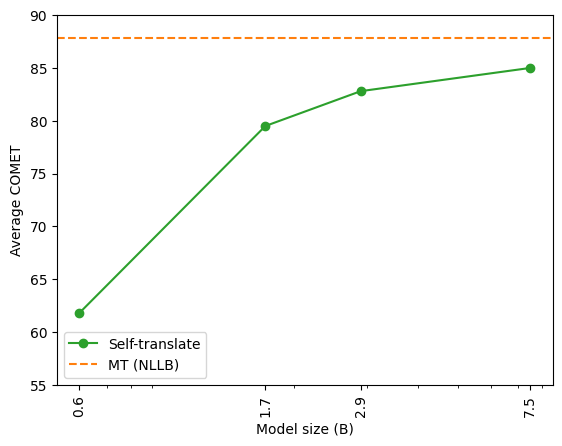

/tmp/ipykernel_964818/569464905.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_avg[average][average] = df_avg[average].mean(axis=1).round(1)


,model,size,xstory_cloze,xcopa,xnli,low
nllb-200-distilled-600M,nllb,0.6,86.2,76.8,82.1,81.7
nllb-200-distilled-1.3B,nllb,1.3,87.7,79.6,83.2,83.5
nllb-200-1.3B,nllb,1.3,87.8,78.7,83.0,83.2
nllb-200-3.3B,nllb,3.3,88.1,79.7,83.5,83.8
xglm-564M,xglm,0.6,59.0,56.0,60.9,58.6
xglm-1.7B,xglm,1.7,74.2,68.8,69.9,71.0
xglm-2.9B,xglm,2.9,79.0,72.0,74.0,75.0
xglm-7.5B,xglm,7.5,82.6,74.8,77.4,78.3
bloom-560m,bloom,0.6,55.3,45.3,64.7,55.1
bloom-1b7,bloom,1.7,68.5,54.4,69.4,64.1


/tmp/ipykernel_964818/569464905.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_avg[average].to_latex(index=False))


\begin{tabular}{lrrrrr}
\toprule
model &  size &  xstory\_cloze &  xcopa &  xnli &  low \\
\midrule
 nllb &   0.6 &          86.2 &   76.8 &  82.1 & 81.7 \\
 nllb &   1.3 &          87.7 &   79.6 &  83.2 & 83.5 \\
 nllb &   1.3 &          87.8 &   78.7 &  83.0 & 83.2 \\
 nllb &   3.3 &          88.1 &   79.7 &  83.5 & 83.8 \\
 xglm &   0.6 &          59.0 &   56.0 &  60.9 & 58.6 \\
 xglm &   1.7 &          74.2 &   68.8 &  69.9 & 71.0 \\
 xglm &   2.9 &          79.0 &   72.0 &  74.0 & 75.0 \\
 xglm &   7.5 &          82.6 &   74.8 &  77.4 & 78.3 \\
bloom &   0.6 &          55.3 &   45.3 &  64.7 & 55.1 \\
bloom &   1.7 &          68.5 &   54.4 &  69.4 & 64.1 \\
bloom &   3.0 &          72.0 &   56.4 &  72.8 & 67.1 \\
bloom &   7.1 &          74.3 &   59.3 &  76.2 & 69.9 \\
llama &   7.0 &          54.5 &   49.8 &  57.4 & 53.9 \\
llama &  13.0 &          55.4 &   49.7 &  62.0 & 55.7 \\
llama &  30.0 &          58.5 &   52.8 &  68.5 & 59.9 \\
\bottomrule
\end{tabular}



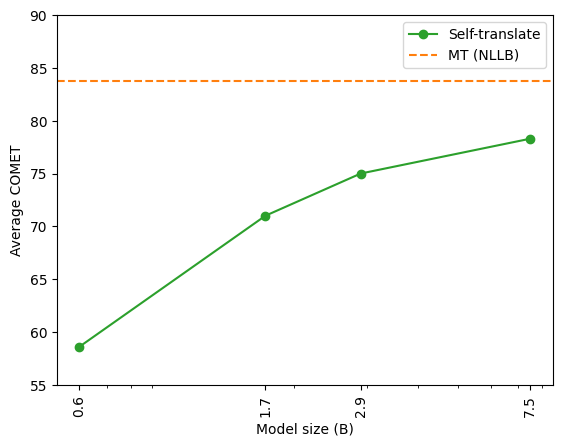

In [23]:
# create plots for each dataset and model

import matplotlib.pyplot as plt
import pandas as pd

def get_dataframes_model(metrics_dict_split, model_name):
    for metric in ["comet"]: # ["sacrebleu", "chrf++", "comet"]
        df_avg = {}
        for average in ["avg"] + list(languages.keys()):
            df_avg[average] = pd.DataFrame({"model": _MODELS}, index=_MODELS)
        for dataset_name in metrics_dict_split[metric]:
            df = pd.DataFrame(metrics_dict_split[metric][dataset_name]).T
            for average in ["avg"] + list(languages.keys()):
                df_avg[average][dataset_name] = df[average]
            df["model"] = model_names_all
            df["size"] = model_sizes_all
            df = df.reindex(columns=["model", "size"] + [col for col in df.columns if col not in ["model", "size"]])
            display(df)
            print(df.to_latex(index=False))
            # x labels vertical
            plot_size_df_datasets(df, model_name, f"{dataset_name} {metric}")
        for average in ["avg"] + list(languages.keys()):
            df_avg[average][average] = df_avg[average].mean(axis=1).round(1)
            df_avg[average]["model"] = model_names_all
            df_avg[average]["size"] = model_sizes_all
            df_avg[average] = df_avg[average].reindex(columns=["model", "size"] + [col for col in df_avg[average].columns if col not in ["model", "size"]])
            display(df_avg[average])
            print(df_avg[average].to_latex(index=False))
            plot_size_df_datasets(df_avg[average], model_name, title="")

get_dataframes_model(metrics_dict_split, "xglm")